# Data Science in Transportation
***
## Step-by-step tutorial with `python` `pandas` and NYC citi bikes data
***
> (c) Rafal Kucharski Cracow University of Technology, Poland, rkucharski_at_pk.edu.pl

<img src="./data/newplot.png">
In this demo you will learn how to download, preprocess, process, filter, analyze, understand, synthesize and visualize data from over 4 000 000 bike trips recorded on summer 2017 in NYC.

Specifically you will:
1. download the online data from static files (zipped csv).
2. parse it to `pandas DataFrame` - powerful data structure for data science.  
3. download the online real-time data from json files and parse it to `pandas DataFrame`
4. inspect the data stored in `pandas.DataFrame`, view columns, index, rows, filter the data, statstically descibe it.
5. plot the data on matplotlib and plotly graphs
6. plot data on the map with `plotly`
7. filter the data, group it, create multiindexes, pivot it, concatenate it, fill nans, cut tails over 95th percentile and more useful `pandas` tricks.
8. create and use powerful `datetimeindex`
9. plot histograms, regression plot, heatmap with `seaborn`
10. create station statistics from the trip records
11. create matrices, OD matrix and travel times matrix.
12. fit the observed data to the best of selectged four distributions with `scipy`
13. Aggregate the data over the days, to understand the mobility over the weekdays, hours, etc.
14. Fuse the real-time data of station loads with the historical data to visualise predicated situation at a selected bicycle station.

The examples presented are aimed to cover most of functionalities needed to kick-off with data science using python, pandas and other powerful modules like sklearn, scipy and numpy and visualize it with matplotlib, plotly and seaborn.



# Prerequisites
Before you start make sure you have installed:
* [python](https://www.python.org/downloads/) (tested for 3.6.3 version)
* python IDE (personally I reccommend [pyCharm](https://www.jetbrains.com/pycharm/))
* pip integrated with shell, so that `pip install pandas` will work (in case of problems, which are common, keep calm and refer to this [SO post](https://stackoverflow.com/questions/4750806/how-do-i-install-pip-on-windows)


### Modules needed
make sure this code will work in your python IDE [how-to](https://www.jetbrains.com/help/pycharm/running-console.html)
if any line of the code raises error, try calling `pip install module name` from your console, or [use PyCharm](https://www.jetbrains.com/help/pycharm/installing-uninstalling-and-upgrading-packages.html). 

*** 
before entering the classrom make sure, you can execute the below cell in jupyter and it will not raise errors.
possible problems:
* not installed modules: call `pip install module`, or [use PyCharm](https://www.jetbrains.com/help/pycharm/installing-uninstalling-and-upgrading-packages.html). 
* no pip available from pycharm / cmd (shell, terminal, command line) please consult this [SO post](https://stackoverflow.com/questions/4750806/how-do-i-install-pip-on-windows), otherwise try installing [anaconda](https://www.anaconda.com/download/#windows) and run jupyter directly from the installed jupyter appliaction.
* jupyter not running [run jupyter from pyCharm](https://www.jetbrains.com/help/pycharm/using-ipython-notebook-with-product.html)

In [1]:
import os  # operating system calls
import pandas as pd  # coolest data sceince python module - extremely flexible and efficient
import zipfile  # unzips zipped zips
import matplotlib.pyplot as plt  # plots old school style, if you do not want plot.ly or sth similar
import numpy as np  # math operations
#from shapely.geometry import Point  # shapefile like add-on for pandas
import plotly.plotly as py  # plot.ly python wrapper
from plotly.graph_objs import Data, Scattermapbox, Marker, Layout, Box  # plotly objects
import requests  # to scrap the data from the web
import scipy.stats as st  # statistical 
import seaborn as sns  # statistical fancy tools
import warnings  # python runtime warnings
import scipy.stats as scipystats  # statistical models
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances  # the classical mighty machine learning module
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

### Constants
here I store paths, constants, styles, and all the code constants (parameters). I encourage you to use config.json for more complex solutions [SO post](https://stackoverflow.com/questions/19078170/python-how-would-you-save-a-simple-settings-config-file)

In [2]:
topsize = 30

LOW_WARN = 3
HIGH_WARN = 3

PLOT_STYLES = dict(
    OK={'color': 'green', 'lw': 1, 'linestyle': '-'},
    FULL={'color': 'red', 'lw': 2, 'linestyle': ':'},
    EMPTY={'color': 'black', 'lw': 2, 'linestyle': ':'},
    LOW={'color': 'yellow', 'lw': 1, 'linestyle': '--'},
    HIGH={'color': 'yellow', 'lw': 1, 'linestyle': '--'})


# 1.Data import
> Use downloaded data, unzip it, parse to useful data structure

We use freely available datasets provided by _citi bike_ available [here](https://www.citibikenyc.com/system-data)
in this tutorial we focus on the historical data sets provided in this [amazon bucket](https://s3.amazonaws.com/tripdata/index.html)
<br>
for stability I copied three selected months (summer 2017) data to the repo [folder](https://github.com/RafalKucharskiPK/DataScience_for_TransportationResearch/tree/master/data)

Here we:
* walk through the `./data/` folder, 
* unzip all .zip archives to '.csv',
* parse all `.csv.` files to `pandas DataFrame` (`pd.read_csv()`),
* index the `DataFrame` by `datatimeindex` (useful for futher time related calculations)
* concat several DataFrames to get a single processable data source (`pd.concat`).
* delete unused data `del df[col]`


In [3]:
trips = list()  # list of pd.dfs to be populated with csv data and concatenated to a single DataFrame
plot_x = list()  # data to be plotted in the next cell
plot_y = list()

for file in os.listdir("./data/"):  # loop over files in the directory
    if file.endswith(".zip"):  # parse only .zip archives
        zip_ref = zipfile.ZipFile(os.path.join("./data/", file), 'r')  # unzip
        df = pd.read_csv(zip_ref.extract(zip_ref.filelist[0]))  # parse to pd.DataFrame
        df["starttime"] = pd.to_datetime(df["starttime"], format="%Y/%m/%d %H:%M:%S")  # use 'starttime' column as index and parse it to datetime
        df.index = df["starttime"]
        del df["starttime"]  # now this column can be dropped (it is already an index)
        trips.append(df) # add pasred pd.DataFrame to list

        plot_x.append(file.split("-")[0])  
        plot_y.append(trips[-1].shape[0])
        print("Reading {}MB file of {:,} trips recorded on {}"
              .format(int(os.path.getsize(os.path.join("./data/", file)) / 1024 / 1024.0), trips[-1].shape[0], file.split("-")[0]))

trips = pd.concat(trips)  #merge trheee DataFrames to a sinlge 'table' (DataFrame)

# delete unused data
del trips['stoptime']
del trips['start station name']
del trips['end station name']

Reading 60MB file of 1,816,498 trips recorded on 201708
Reading 57MB file of 1,735,599 trips recorded on 201707
Reading 57MB file of 1,731,594 trips recorded on 201706


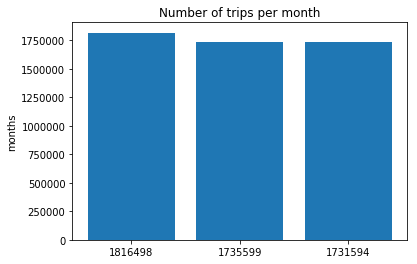

In [4]:
plt.bar([i for i, x in enumerate(plot_x)], plot_y)
plt.xticks([i for i, x in enumerate(plot_x)], plot_y)
plt.ylabel('number of bike rents')
plt.ylabel('months')
plt.title("Number of trips per month")
plt.show()

***
# 2. Inspect, analyze, view the data
> Here we show how to inspect the data, see the rows, columns, describe it statistically, execute bacic operations, filter the data.

In [5]:
trips.columns # columns of the DataFrame

Index(['tripduration', 'start station id', 'start station latitude',
       'start station longitude', 'end station id', 'end station latitude',
       'end station longitude', 'bikeid', 'usertype', 'birth year', 'gender'],
      dtype='object')

In [6]:
trips.head() # brief inspection of first 5 rows of Data

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,birth year,gender
starttime,,,,,,,,,,,
2017-08-01 00:00:00,2110,470,40.74,-74.00,3289,40.79,-73.97,20954,Subscriber,"1,978.00",2
2017-08-01 00:00:10,160,348,40.72,-74.00,151,40.72,-74.00,15164,Subscriber,"1,978.00",1
2017-08-01 00:00:17,1644,3165,40.78,-73.98,3320,40.79,-73.96,17540,Subscriber,"1,962.00",2
2017-08-01 00:00:27,323,389,40.71,-73.97,3073,40.71,-73.95,18705,Subscriber,"1,990.00",1
2017-08-01 00:00:41,109,3145,40.78,-73.96,3147,40.78,-73.95,27975,Subscriber,"1,983.00",1


In [7]:
print("Mean trip duration is: ", trips.tripduration.mean())

Mean trip duration is:  1097.52567646


In [8]:
print("Mean trip duration in July is : ", trips.tripduration[trips.index.month==7].mean())

Mean trip duration in July is :  1060.14335973


In [9]:
print(len(trips[trips['start station id']==470]), "\t trips started at station 470")

12418 	 trips started at station 470


In [10]:
print("Top 10 destinations from station 470")
trips[trips['start station id']==470].groupby('end station id').size().sort_values(ascending=False).head(10)

Top 10 destinations from station 470


end station id
3255    445
459     415
435     385
494     297
523     294
212     264
462     233
402     218
3258    182
382     176
dtype: int64

In [11]:
trips.describe().T  # general statistical description of data in DataFrame columns

,count,mean,std,min,25%,50%,75%,max
tripduration,"5,283,691.00","1,097.53","15,008.01",61.00,394.00,669.00,"1,167.00","4,509,256.00"
start station id,"5,283,691.00","1,352.63","1,342.41",72.00,359.00,485.00,"3,140.00","3,489.00"
start station latitude,"5,283,691.00",40.74,0.04,0.00,40.72,40.74,40.76,45.51
start station longitude,"5,283,691.00",-73.99,0.05,-74.03,-74.00,-73.99,-73.98,0.00
end station id,"5,283,691.00","1,349.57","1,341.92",72.00,359.00,484.00,"3,139.00","3,489.00"
end station latitude,"5,283,691.00",40.74,0.05,0.00,40.72,40.74,40.76,45.51
end station longitude,"5,283,691.00",-73.99,0.07,-74.07,-74.00,-73.99,-73.98,0.00
bikeid,"5,283,691.00","23,240.25","5,012.16","14,529.00","18,443.00","25,228.00","27,788.00","30,827.00"
birth year,"4,637,947.00","1,979.42",11.59,"1,874.00","1,972.00","1,982.00","1,988.00","2,001.00"
gender,"5,283,691.00",1.11,0.59,0.00,1.00,1.00,1.00,2.00


In [12]:
filtered_trips = trips.loc["2017-06-01":"2017-06-10"]  # filter trips to a given date range
print("Between {} and {} there were {} trips".format("2017-06-01","2017-06-10",len(filtered_trips)))

Between 2017-06-01 and 2017-06-10 there were 578562 trips


# 3. Process the data
> Here we use the data from `trips DataFrame` to create the tabel of bicycle stations. We plot its loads (number of trips per station). This is far from optimal, the purpose to explain with illustrative example, not to optimize the code.

Specifically here we:
* use `pd.df[col].unique()` to get unique origin and destination stations.
* merge the two (union on two sets) with `np.union1d` 
* iterate over stations and use mean of its longtitude and latitude 
* use number of origin trips as a futher scale
* use `shapely` to store lonlat Point - for further use in GIS applications.

In [13]:
st = pd.DataFrame(np.union1d(trips['start station id'].unique(),
                             trips['end station id'].unique()),
                  columns=["station_id"])
locs = list()
sizes = list()
for index, row in st.iterrows():
    locs.append(
        [trips[trips['start station id'] == row["station_id"]]['start station longitude'].mean(),
         trips[trips['start station id'] == row["station_id"]]['start station latitude'].mean()]
    )
    sizes.append(len(trips[trips['start station id'] == row["station_id"]]))
                 
#st['pos'] = [Point(loc[0], loc[1]) for loc in locs]
st['lon'] = [loc[0] for loc in locs]
st['lat'] = [loc[1] for loc in locs]
st['orig_trips'] = sizes
stations = st.set_index("station_id")

Now we will plot the data on the map using `plotly`
***

In [14]:
import plotly 
plotly.tools.set_config_file(world_readable=True,
                                sharing='public')
plotly.tools.set_credentials_file(username='rkucharski',
                                     api_key="w1LROCX3bYA8amfuLA4g")
data = [Scattermapbox(
            lat=stations.lat, lon=stations.lon,       
            mode='markers',
            marker=Marker(
                size= 30* (stations.orig_trips / stations.orig_trips.max()),
                opacity=0.7
            ),
            text="Station: ",
            hoverinfo='text'
        )]
    
layout = Layout(
    title='Stations of the system with their capacities',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
            bearing=0,
            center=dict(
                lat=40.75,
                lon=-73.95
            ),
            pitch=0,
            zoom=12,
            style='light'
        ),
    )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='CITI stations')

# 4. Get Real-time data
> Here we use the real time online source of data from https://www.citibikenyc.com/system-data, stored in json-like data online. We process the station_status to see how many bicycles and slots is there available (now).

In [15]:
json = requests.get("https://gbfs.citibikenyc.com/gbfs/en/station_status.json").json()
data = json['data']['stations']
station_status = pd.DataFrame(data)
station_status = station_status.set_index("station_id")

In [16]:
print("Count empty stations")
station_status[station_status.num_bikes_available == 0].shape[0]

Count empty stations


58

In [17]:
print("10 full stations")
station_status[station_status.num_docks_available==0].num_docks_available.nsmallest(10)

10 full stations


station_id
128    0
168    0
242    0
243    0
345    0
347    0
351    0
380    0
385    0
388    0
Name: num_docks_available, dtype: int64

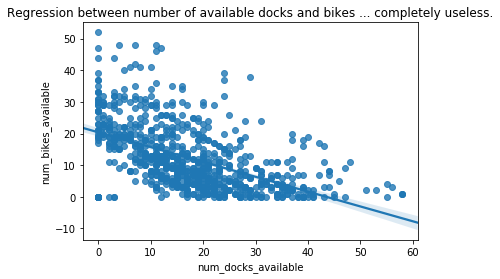

In [18]:
sns.regplot(station_status.num_docks_available, station_status.num_bikes_available)
plt.title("Regression between number of available docks and bikes ... completely useless.")
plt.show()

# 5. Pivot the data to retrieve matrices (OD matrix, travel time matrix)
> Here we use `pandas.groupby` with two group levels to get the od matrix. Then we normalize the data to get splitting rates/probability/shares/...

In [19]:
matrix = trips.groupby(by=['start station id', 'end station id']) # group with two indexes
OD = matrix.size()  # make trip matrix
pd.options.display.float_format = '{:,.0f}'.format
OD = OD.unstack().fillna(0) # fill na with zeros, unstack the column matrix to classic view

In [20]:
OD.head() # show me first 5 rows of the matrix

end station id,72,79,82,83,116,119,120,127,128,143,...,3472,3474,3476,3477,3478,3479,3481,3485,3488,3489
start station id,,,,,,,,,,,,,,,,,,,,,
72,330,12,2,0,17,0,0,69,17,2,...,52,11,0,0,0,0,0,0,0,0
79,32,122,4,3,12,0,1,90,69,0,...,13,28,1,1,0,0,0,0,0,0
82,0,3,137,0,1,4,0,1,34,0,...,4,3,0,0,0,0,0,0,0,0
83,0,1,0,85,0,1,48,2,0,19,...,0,1,0,1,5,0,0,0,0,0
116,40,22,6,0,178,0,1,155,54,0,...,35,9,1,0,0,0,0,0,0,0


Relative matrix

In [21]:
relative_OD = matrix.size().groupby(level=0).apply(lambda x: x / float(x.sum()))
relative_OD = relative_OD.unstack().fillna(0)
pd.options.display.float_format = '{:,.3f}'.format
relative_OD.head()

end station id,72,79,82,83,116,119,120,127,128,143,...,3472,3474,3476,3477,3478,3479,3481,3485,3488,3489
start station id,,,,,,,,,,,,,,,,,,,,,
72,0.026,0.001,0.000,0.000,0.001,0.000,0.000,0.005,0.001,0.000,...,0.004,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
79,0.004,0.014,0.000,0.000,0.001,0.000,0.000,0.010,0.008,0.000,...,0.001,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
82,0.000,0.001,0.034,0.000,0.000,0.001,0.000,0.000,0.008,0.000,...,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
83,0.000,0.000,0.000,0.017,0.000,0.000,0.010,0.000,0.000,0.004,...,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000
116,0.003,0.002,0.000,0.000,0.014,0.000,0.000,0.012,0.004,0.000,...,0.003,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


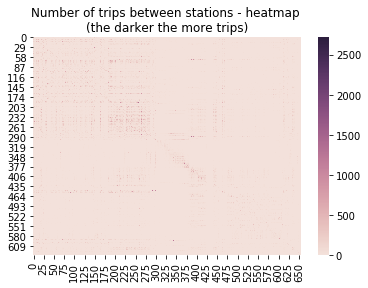

In [22]:
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap.set_under("1.1")
df_mtx = OD.as_matrix()
cmap.set_under(".5")
sns.heatmap(df_mtx, cmap= cmap)
plt.title("Number of trips between stations - heatmap \n(the darker the more trips)")
plt.show()

## 6. Histograms and percentile filtering 
> Here we use retrieve travel times for a given OD pair and plot the distribution of this. After seeing that the right tail is very long, we filter the data to the 95th percentile

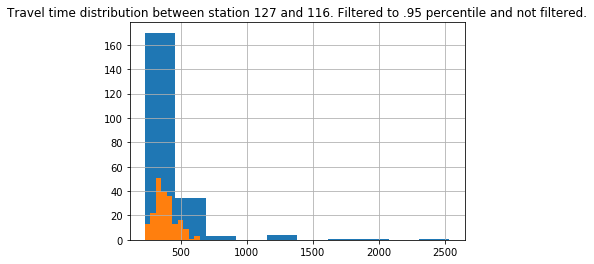

In [23]:
matrix = trips.groupby(by=['start station id', 'end station id'])  # pivot the trips to retrieve the matrix
durations = matrix.get_group((127, 116)).tripduration  # access a single cell of the matrix
durations.hist()
durations = durations[durations < durations.quantile(0.95)]  # filter below the given percentile
durations.hist()

plt.title("Travel time distribution between station 127 and 116. Filtered to .95 percentile and not filtered.")
plt.show()

## 7. Distribution fitting
> Here we fit the observed distribution of travel times. We use scipy to fit some selected fundamental distributions. We try to find the one with the lowes sse error. Here the gamma distribution fits the best, surprisinlgy lognorm distribution failed to fit.

norm	rsse:0.0047132	 loc: 380.8	 scale: 380.8
logno	rsse:0.0163632	 loc: 229.0	 scale: 229.0
gamma	rsse:0.0037867	 loc: 155.7	 scale: 155.7
rayle	rsse:0.0041677	 loc: 221.9	 scale: 221.9

best 	: 	 gamma


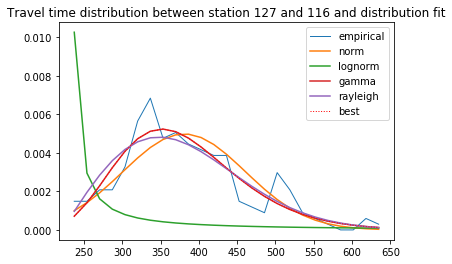

In [24]:
data = durations.as_matrix()  # we use the duration and parse it to numpy
y, x = np.histogram(data, bins=25, density=True)  # this is the data from the histogram that we will be fitting
x = (x + np.roll(x, -1))[:-1] / 2.0  # we roll the bins and use middle of each bein as the 'x'

distributions = [scipystats.norm, scipystats.lognorm, scipystats.gamma, scipystats.rayleigh]  # four selected distributions to fit

best_sse = np.inf  # ref best value to be overwritten

plt.plot(x, y, lw=1, label = "empirical", linestyle="-")  # set the mapltolib layout
for distribution in distributions:

    params = distribution.fit(data)  # do the fitting (assume uniform distribution of x in the data)

    arg = params[:-2]  # other parameters of the distribution (if any)
    loc = params[-2]  # location parameter of the distribution
    scale = params[-1]  # scale parameter of the distribution
    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg) # reproduce the pdf
    rsse = np.sqrt(np.sum(np.power(y - pdf, 2.0)))  # calulate the error
    print(distribution.name[:5] + "\trsse:" + '%.7f' % rsse + "\t loc: " + '%.1f' % loc + "\t scale: " + '%.1f' % loc)
    plt.plot(x, pdf, label = distribution.name) # plot the fitted distribution.

    if best_sse > rsse > 0:  # store this solution if best
        best_distribution = distribution
        best_params = params
        best_sse = rsse

print("\nbest \t: \t " + best_distribution.name)
best_pdf = best_distribution.pdf(x, loc=best_params[-2], scale=best_params[-1], *best_params[:-2])
plt.plot(x, best_pdf, lw=1, linestyle =":", color='red', label = 'best')
plt.title("Travel time distribution between station 127 and 116 and distribution fit")
plt.legend()
plt.show()

## 8. Data syntesis
> Here we aggregate the trips by day and provide basic statistics of a day. Usin goupby and pivot on the trips dataframe

In [25]:
hours = trips['bikeid'].groupby(by=[trips.index.date, trips.index.hour]).count()  # total trips per day,  hour
hours = hours.reset_index()  # flatten the multiindex pandas data frame
hours.columns = ["date", "hour", "trips"]  # make understandable index names
days = hours.pivot(index="date", columns='hour', values='trips')  # use hours as columns (fields)
days['totals'] = trips['bikeid'].groupby(by=[trips.index.date]).count()  # add totals
days.index = pd.to_datetime(days.index)
days["weekday"] = days.index.dayofweek

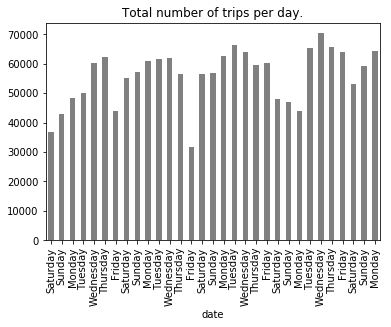

In [26]:
ax = days[days.index.month==7].totals.plot(kind='bar', color = 'grey')
plt.title("Total number of trips per day.")
ax.set_xticklabels(days[days.index.month==7].index.weekday_name)
plt.show()

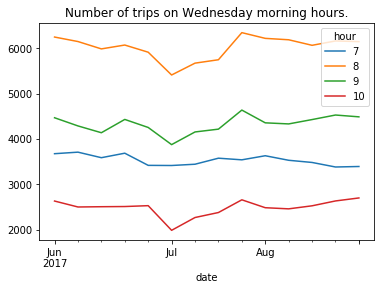

In [27]:
days[days.weekday == 3][[7, 8, 9, 10]].plot()
plt.title("Number of trips on Wednesday morning hours.")
plt.show()

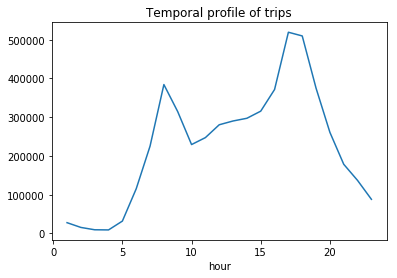

In [28]:
days[list(range(1, 24))].sum().plot()
plt.title("Temporal profile of trips")
plt.show()

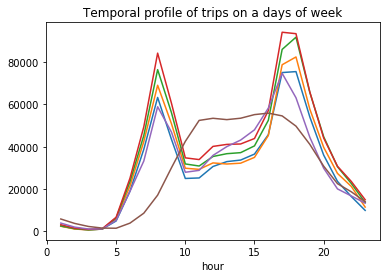

In [29]:
for i in range(6):
    days[list(range(1, 24))][days.index.weekday == i].sum().plot()

plt.title("Temporal profile of trips on a days of week")
plt.show()

## 9. Station loads
> Here we synthesize the station rentals and drops and visualize the results

In [30]:
agg = "5min"  # time window to aggregate the data
date_from="2017-08-01"  # visualized day
_trips = trips.loc[date_from]
# this table is:
# time as index (row),
# start_station_id in columns,
# bikeid when bike is rented from station (col) at time(row),
# NaN otherwise
rentals = _trips.pivot_table(index=_trips.index, columns='start station id', values='bikeid')
# now we make it to boolean (1 for rentals, and 0 for all NaN's)
# we resample it for 5min (param) intervals and do the cumulative sum
rentals = rentals.notna().resample(agg).sum().cumsum().ffill()
# the same with dropsin
# we need the drop timestamp
_trips = _trips.drop(_trips[_trips.tripduration > 7200].index)
_trips = _trips.assign(drop_time=pd.Series(_trips.index + pd.to_timedelta(_trips.tripduration, unit='s')).values)

drops = _trips.pivot_table(index=_trips.drop_time, columns='end station id', values='bikeid')
drops = drops.notna().resample(agg).sum().cumsum().ffill().bfill()

multiindex = {"rentals": rentals, "drops": drops}  # make data for multilevel column index
balance = pd.concat(multiindex.values(), axis=1, keys=multiindex.keys())  # join two tables on columns (outer)
balance.rentals = balance.rentals.ffill()  # fill intervals with no rents/drops with 0
balance.drops = balance.drops.bfill()  # fill intervals with no rents/drops with 0
balance.columns = balance.columns.swaplevel()  # swap the levels of multilevel index (more useful)


#### Describe station loads

In [31]:
initial_loads = station_status.num_bikes_available
capacities = station_status.num_bikes_available+station_status.num_docks_available
for station_id in set(balance.columns.get_level_values(0)):
    if ('rentals' in list(balance[station_id].columns)) and\
            ('drops' in list(balance[station_id].columns)):
        initial_load = initial_loads.loc[station_id] if station_id in initial_loads else 15
        capacity = capacities.loc[station_id] if station_id in capacities else 15
        # print("station: {}, capacity: {}, initial load: {}".format(station_id, capacity, initial_load))

        balance[station_id, "total"] = initial_load + balance[station_id].drops - balance[station_id].rentals
        alerts = list()
        for tot in balance[station_id, "total"]:
            if tot < 0:
                alerts.append("EMPTY")
            elif tot < LOW_WARN:
                alerts.append("LOW")
            elif tot >= capacity:
                alerts.append("FULL")
            elif tot >= capacity - HIGH_WARN:
                alerts.append("HIGH")
            else:
                alerts.append("OK")
        balance[station_id, "alerts"] = alerts

#### Plot station status

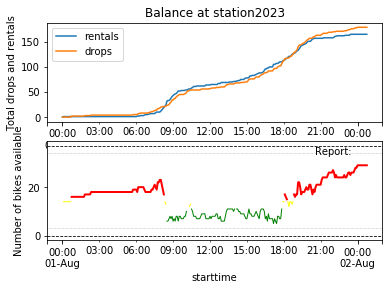

In [32]:
station = balance[72]  #set the station to visualize
fig, axes = plt.subplots(nrows=2, ncols=1)  # define matplotlib layout
station[['rentals', 'drops']].plot(ax=axes[0])  # cumulated renatls and drops
_cap = station_status.iloc[72].num_bikes_available+station_status.iloc[72].num_docks_available
#plot conditioanlly station load temporal profile
for i in station.alerts.unique():
    df = station.where(station.alerts == i).total
    df.plot(ax=axes[1], color=PLOT_STYLES[i]['color'], lw=PLOT_STYLES[i]['lw'])

axes[1].axhline(y=_cap,color='black', linestyle='--', lw=0.8)
axes[1].axhline(y=_cap-HIGH_WARN,color='gray', linestyle=':', lw=0.5)
axes[1].axhline(y=LOW_WARN,color='gray', linestyle=':', lw=0.5)
axes[1].axhline(y=0,color='black', linestyle='--', lw=0.8)

axes[0].set_ylabel("Total drops and rentals")
axes[1].set_ylabel("Number of bikes available")
axes[0].set_title('Balance at station' + str(station_id))


plt.text(0.8, 0.9, "Report:", horizontalalignment='left', verticalalignment='center', transform=axes[1].transAxes)
#plt.text(0.8, 0.8, "lost drops: "+str(int(report['lost_drops'])), horizontalalignment='left',
#         verticalalignment='center', transform=axes[1].transAxes)
#plt.text(0.8, 0.7, "lost rentals: " + str(int(report['lost_rents'])), horizontalalignment='left',
#         verticalalignment='center',
#         transform=axes[1].transAxes)

plt.show()


# Summary
Thanks to above steps you've learned basics and more of playing with data (big data) using capable freely available python libraries.
The step-by-step hands on exemples allowed you to understand the basic calls, fucntions, methods and workflow of playing with data.
You can get back to this tutorial and many of problems you might encounter can be soolved with the snippets of this notebook.
***
Further reading:
1. stackoverflow.com
2. stackoverflow.com
3. number of wonderful data mining, data science, pandas blogs, tutorials available online - I am not naming any, just google your problem and for sure some clear and self explanatory tutorial/blog will appear.

# Excercises:
To master the above skills, let's take a look at the following excercises.

#### Getting the data
1. How many trips were recorded on Feb 2017 (use data from different csv file, download it, unzip it and query pandas (section 1 and 2 of this notebook)?
2. Try to retrieve the station names of stations from https://gbfs.citibikenyc.com/gbfs/es/station_information.json. 
3. Save station DataFrame to csv.
4. And load it back.

#### Pandas play with data
1. What is the average tripduration (in the dataset that we used) for users above 40 years and is it above average?
2. What is the share of women using station 151?
3. What is the average duration of trips to station 389?
4. Find the non-diagonal OD pair with highest number of trips.
5. Prepare the OD matrix for July only.
6. Filter the trips of duration above 95 percentile.

#### Statistics:
1. What is the distribution of trips from station 389: mean, std, min, max, quantiles?
2. Is the age of biker correlated with the trip duration? try (`.corr()`), inspect the correlation with (`sns.regplot`) and try to fit the model with `sklearn.linear_model` (not covered in this course)
3. Try to fit the trip duration model for all the trips (gravity model)
4. What is mean daily number of trips and the confidence interval on the full dataset and on Tuesdays only - is the confidence interval narrower?



#### Visualize the data:
1. Plot total number of trips by women and men on the bar plot.
2. Plot the actual station loads on plotly map.
3. Plot the birthyear histogram
4. Plot temporal profile (hourly) on number of trips on Tuesdays
5. Visualize on plotly center of gravity of trip origins (lon, lat) and destinations at 7AM and at 4PM.


***
(c) Rafal Kucharski, Cracow University of Technology, Poland, rkucharski_at_pk.edu.pl